In [21]:
import warnings
warnings.filterwarnings("ignore")
from torch import nn, optim, utils
import torch
import os
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
from sklearn import preprocessing
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader


def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2
    
def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides.
    nuc_d = {'a' :[1 ,0 ,0 ,0] ,'c' :[0 ,1 ,0 ,0] ,'g' :[0 ,0 ,1 ,0] ,'t' :[0 ,0 ,0 ,1], 'n' :[0 ,0 ,0 ,0]}
    vectors = np.empty([len(df), seq_len, 4])
    for i, seq in enumerate(df[col].str[:seq_len]):
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


class VEE5UTRDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X,dtype=torch.float)
        self.y = torch.tensor(y.values,dtype=torch.float).reshape((-1, 1))

    def __getitem__(self, item):
        return self.X[item], self.y[item]

    def __len__(self):
        return len(self.y)

    
def evaluate(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''

    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1, 1))
    model.eval()
    # Make predictions
    test_seq = torch.tensor(test_seq, dtype=torch.float)
    predictions = model(test_seq).reshape(-1, 1).detach().numpy()
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:, output_col] = scaler.inverse_transform(predictions)
    return df

class CNN(nn.Module):

    def __init__(self,  input_size=44, layers=3, filters = 120,kernel_size = 8,hidden_size=40):
        super(CNN, self).__init__()
        self.conv = nn.Sequential()
        self.input_size = input_size
        for i in range(layers):
            input_size = filters if i else 4
            self.conv.append(nn.Sequential(
                nn.Conv1d(in_channels=input_size, out_channels=filters, kernel_size=(kernel_size,), padding="same"),
                nn.LeakyReLU(),
                ))
        self.dense = nn.Linear(filters*self.input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(hidden_size, 1)
        self.init()

    def init(self):
        # nn.init.xavier_uniform_(self.dense.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.xavier_uniform_(self.output.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.kaiming_uniform_(self.dense.weight)
        nn.init.kaiming_uniform_(self.dense.weight)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.output(x)
        # x = torch.tanh(x)
        return x

setup_seed(1337)

In [23]:
import sys
sys.path.append("../../")
import tqdm
from src.utils import EarlyStopping

# df, seq_len, epochs = pd.read_csv("../../data/VEE_3UTR/VEE_3UTR.csv"), 118, 10
# plasmid_gate, rna_gate = 20, 4
df, seq_len, epochs = pd.read_csv("../../data/VEE_5UTR_0611/VEE-0611.csv"), 44, 8
plasmid_gate, rna_gate = 30, 5
df = df[(df["rna_counts"] > rna_gate) & (df["plasmid_counts"] > plasmid_gate)]
e_train = df.sample(frac=0.80)
e_test = df[~df.index.isin(e_train.index)]
seq_e_train = one_hot_encode(e_train, seq_len=seq_len)
seq_e_test = one_hot_encode(e_test, seq_len=seq_len)

# Scale the training mean ribosome load values
e_train.loc[:, 'scaled_rl'] = preprocessing.StandardScaler().fit_transform(
        e_train.loc[:, 'score'].values.reshape(-1, 1))
e_test.loc[:, 'scaled_rl'] = preprocessing.StandardScaler().fit_transform(
    e_test.loc[:, 'score'].values.reshape(-1, 1))
train_dt = VEE5UTRDataset(seq_e_train, e_train["scaled_rl"])
test_dt = VEE5UTRDataset(seq_e_test, e_test["scaled_rl"])
batch_size, filters, kernel_size, lr, hidden_size = 128, 120, 8, 1e-3, 40 
train_loader = DataLoader(train_dt, batch_size=batch_size)
test_loader = DataLoader(test_dt, batch_size=batch_size)
model = CNN(input_size=seq_len, filters=filters, kernel_size=kernel_size, hidden_size=hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
criterion = torch.nn.MSELoss()
valid_epochs_loss = []
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=lr*0.01)
early_stopping = EarlyStopping(patience=3)
for epoch in range(epochs):
    model.train()
    valid_epoch_loss = []
    for idx, (data_x, data_y) in tqdm.tqdm(enumerate(train_loader),total=len(train_loader)):
        data_x = data_x.to(torch.float32)
        data_y = data_y.to(torch.float32)
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y, outputs)
        loss.backward()
        optimizer.step()
    model.eval()
    for idx, (data_x, data_y) in enumerate(test_loader):
        data_x = data_x.to(torch.float32)
        data_y = data_y.to(torch.float32)
        outputs = model(data_x)
        loss = criterion(data_y, outputs)
        valid_epoch_loss.append(loss.item())
    valid_loss = np.average(valid_epoch_loss)
    valid_epochs_loss.append(valid_loss)
    lr_scheduler.step()
    print("epoch={}/{} of train, lr={}, valid loss={}".format(epoch + 1, epochs, lr_scheduler.get_last_lr(),  valid_loss))
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        break
    model.eval()
e_test = evaluate(e_test, model, seq_e_test, 'score', output_col='pred')
r = r2(e_test['score'], e_test['pred'])
print('r-squared = ', r)

r = pearsonr(e_test['pred'], e_test['score'])
print('pearsonr = ', r)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:20<00:00,  5.52it/s]


epoch=1/8 of train, lr=[0.00095], valid loss=0.23679815711719648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.83it/s]


epoch=2/8 of train, lr=[0.0009025], valid loss=0.20688346480684622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.72it/s]


epoch=3/8 of train, lr=[0.000857375], valid loss=0.19745094275900296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.87it/s]


epoch=4/8 of train, lr=[0.0008145062499999999], valid loss=0.18704816299889768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.88it/s]


epoch=5/8 of train, lr=[0.0007737809374999998], valid loss=0.17831400568996156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.87it/s]


epoch=6/8 of train, lr=[0.0007350918906249997], valid loss=0.1829486885773284
INFO: Early stopping counter 1 of 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.76it/s]


epoch=7/8 of train, lr=[0.0006983372960937497], valid loss=0.19615521681095874
INFO: Early stopping counter 2 of 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:19<00:00,  5.79it/s]


epoch=8/8 of train, lr=[0.0006634204312890621], valid loss=0.190668816678226
INFO: Early stopping counter 3 of 3
INFO: Early stopping
r-squared =  0.8274153522079584


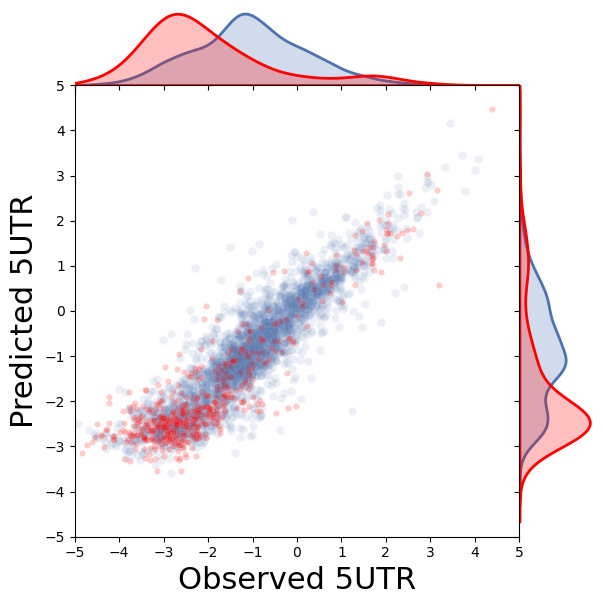

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
atg = e_test[e_test['seq'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['seq'].apply(lambda x: 'ATG' not in x)]
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='score', y="pred", data=atg, space=0, ratio=6)
g.plot_joint(plt.scatter,color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(-5,5.01, 1));
# ax.set_yticklabels(range(-5,5),size=10);
ax.set_xticks(np.arange(-5,5.01, 1));
# ax.set_xticklabels(range(1,5),size=10);
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed 5UTR', 'Predicted 5UTR', **{'size':22});

g.x = n_atg['score'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig